# gempakIO Examples
Nathan Wendt ([email](mailto:nathan.wendt@noaa.gov)) ([@nawendt](https://www.twitter.com/nawendt))  
Meteorologist  
[NWS SPC](https://www.spc.noaa.gov)

This notebook will expose you to the basic usage of gempakIO and how to load and extract data as well as write files in GEMPAK format. To do that, we will go way back to April 3, 1974, the day of the Super Outbreak.

### Imports

In [1]:
import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy.calc as mpcalc
from metpy.plots import Hodograph, SkewT, StationPlot
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pyproj

from gempakio import GempakGrid, GempakSounding, GempakSurface, GridFile, SoundingFile, SurfaceFile

### Misc.

In [2]:
def KTOF(T):
    return T * (9/5.) - 459.67

segment1 = colors.LinearSegmentedColormap.from_list('dewpt1', [(.541,.396,.286), (.286,.255,.212), (.592,.569,.498), (1,1,1)], 30)
segment2 = colors.LinearSegmentedColormap.from_list('dewpt2', [(.894,.961,.894), (.035,.298,.035)], 10)
segment3 = colors.LinearSegmentedColormap.from_list('dewpt3', [(.38,.639,.686), (.075,.169,.165)], 5)
segment4 = colors.LinearSegmentedColormap.from_list('dewpt4', [(.404,.42,.612), (.169,.141,.404)], 5)

DEWPT_LEVELS = np.arange(-20,82,2)
DEWPT_COLORS = np.asarray([ segment1(x) for x in np.linspace(0.,1.,segment1.N) ] +
                          [ segment2(x) for x in np.linspace(0.,1.,segment2.N) ] +
                          [ segment3(x) for x in np.linspace(0.,1.,segment3.N) ] +
                          [ segment4(x) for x in np.linspace(0.,1.,segment4.N) ])

DEWPT_CMAP = colors.ListedColormap(DEWPT_COLORS)
DEWPT_CMAP.set_over((.471,.282,.439))
DEWPT_CBTIX = np.arange(-20,90,10)
DEWPT_NORM = colors.BoundaryNorm(DEWPT_LEVELS, DEWPT_CMAP.N)

# Importing Data

## Reading Grids

Reading grids, or any data, is fairly straightforward. You need to instantiate the appropriate class and give it the GEMPAK file. For grids, you will need to use the `GempakGrid` class. Here, we use data from an Eta model re-run for the Super Outbreak of 1974. We will extract MLSP and surface dewpoints and plot them.

In [3]:
atmo_grid = GempakGrid('data/eta_740403_1200_f006.grd')

Extracting data is also quite simple. It works similarly to GEMPAK in that you can select a subset of the data. If no subsetting parameters are given, the entire dataset will be decoded and returned. For each matching grid, an `xarray.DataArray` will be returned in a list.

In [4]:
pmsl = atmo_grid.gdxarray(parameter='PMSL')[0]
sfc_dewpt = atmo_grid.gdxarray(parameter='DWPF')[0]

### Plot

In [5]:
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6371200.0, semiminor_axis=6371200.0)

To plot you will need to have the CRS information of the grid. Grids have the CRS information embedded within them as a `pyproj.CRS` object. You can retrieve it as follows:

In [6]:
atmo_grid.crs

<Projected CRS: +proj=lcc +lon_0=-95.0 +lat_1=25.0 +lat_2=25.0 +el ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [7]:
proj = ccrs.LambertConformal(central_longitude=-95.0, standard_parallels=(25.0,25.0), globe=globe)

Geographic coordinates are also created and stored within the `GempakGrid` obect.

In [8]:
lon = atmo_grid.lon
lat = atmo_grid.lat

/Users/nawendt/opt/miniconda3/envs/md/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/nawendt/opt/miniconda3/envs/md/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


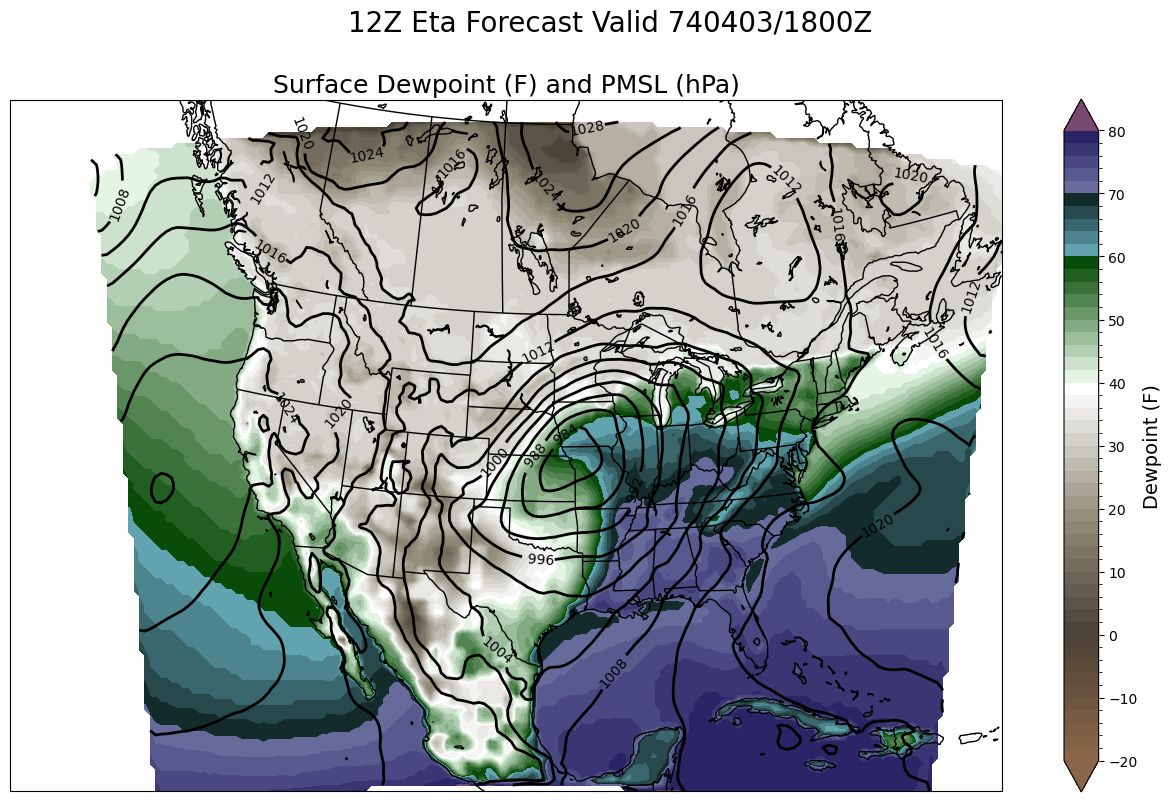

In [9]:
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection=proj)
cbax = ax.contourf(lon, lat, sfc_dewpt[0,0,...], transform = ccrs.PlateCarree(), 
                     cmap=DEWPT_CMAP, norm=DEWPT_NORM, levels=DEWPT_LEVELS, extend='both')
ctax = ax.contour(lon, lat, pmsl[0,0,...], levels = np.arange(980, 1044, 4), 
                  colors = 'k', transform = ccrs.PlateCarree(),
                  linewidths = 2)
plt.clabel(ctax, inline = True, fmt = '%4d')
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.coastlines('50m')
ax.add_feature(feature.BORDERS)
plt.title('Surface Dewpoint (F) and PMSL (hPa)', fontsize=18)
plt.suptitle('12Z Eta Forecast Valid 740403/1800Z', fontsize=20)
cb = plt.colorbar(cbax, ax = ax)
cb.set_label(label='Dewpoint (F)', fontsize=14)
cb.set_ticks(DEWPT_CBTIX)

## Reading Soundings

The `GempakSounding` class is used for vertical profiles. Let's plot a sounding from Nashville, TN from 1 PM CDT on April 3, 1974.

In [10]:
raobs = GempakSounding('data/19740403_upa.snd')

Could not interpret data source `1952805748`. Setting to `Unknown`.


Selecting a station is identical to grids, only with a different set of paramters to use. The resulting matched stations will be returned as a list of `xarray.Dataset`.

In [11]:
bna = raobs.snxarray(station_id='BNA', date_time='197404031800')[0]

In [12]:
hght = bna.hght.values.squeeze() * units.m
p = bna.pres.values * units.hPa
T = bna.tmpc.values.squeeze() * units.degC
Td = bna.dwpc.values.squeeze() * units.degC
wind_speed = bna.sknt.values.squeeze() * units.knots
wind_dir = bna.drct.values.squeeze() * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

### Plot

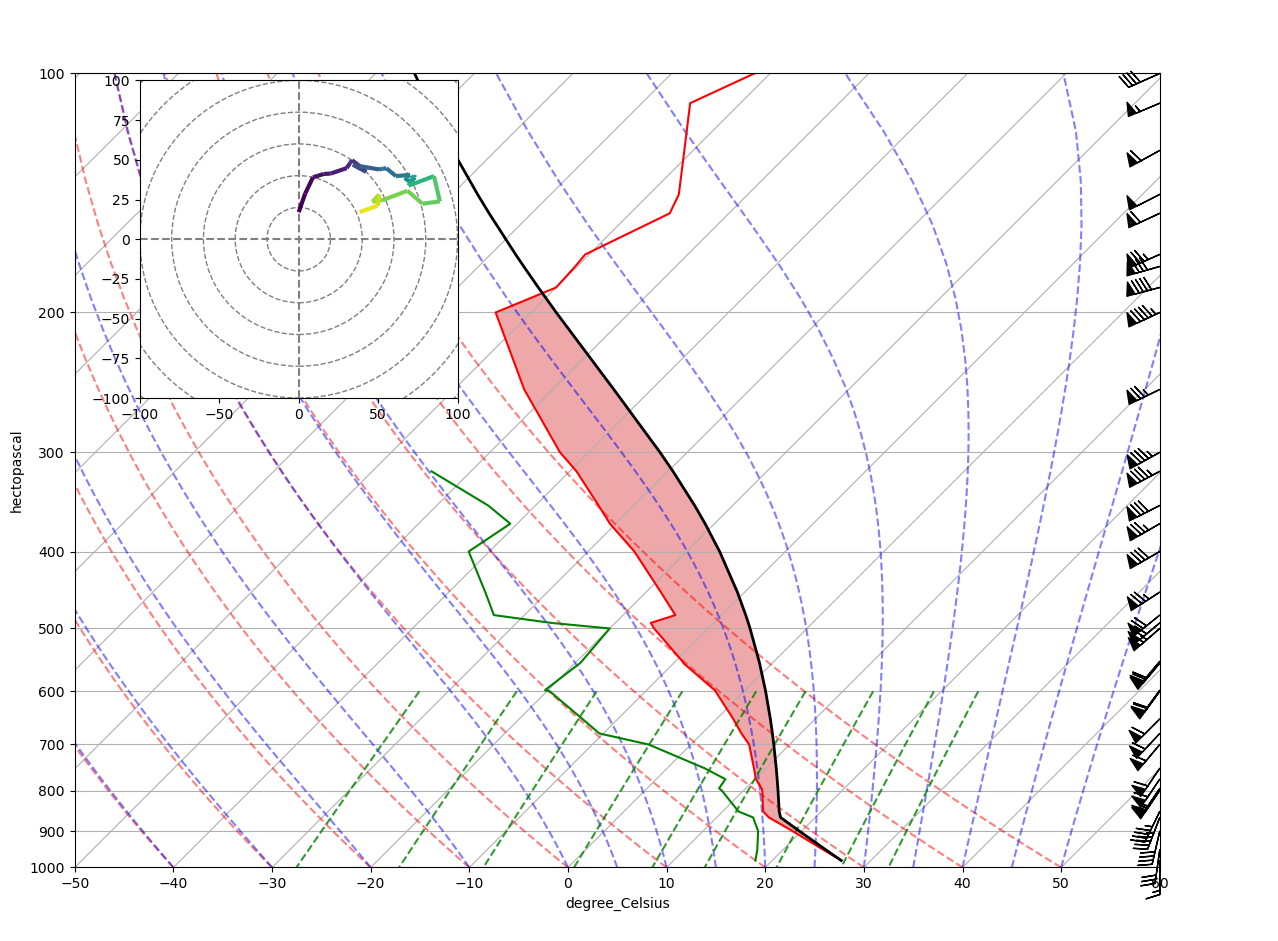

In [13]:
fig = plt.figure(figsize=(14, 14))

skew = SkewT(fig, rotation=45)

skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_xlim(-50, 60)

# We need to skip the first level as that is a mandatory level that is
# below ground.
prof = mpcalc.parcel_profile(p[1:], T[1], Td[1])
skew.plot(p[1:], prof, 'k', linewidth=2)
skew.shade_cape(p[1:], T[1:], prof)

ax_hod = inset_axes(skew.ax, '40%', '40%', loc=2)
h = Hodograph(ax_hod, component_range=100.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, hght)

## Reading Surface Data

Surface data is read by the `GempakSurface` class. We will load and plot METAR data from 1 PM CDT on April 3, 1974.

In [14]:
metars = GempakSurface('data/19740403_sao.sfc')

As before, the slection process works the same. This is the most likely place to see subsetting. As you will see in the plot, you can have very dense station data in some areas. xarray objects are not used for surface data. Instead, a list of JSON objects (or dictionaries, really) are returned.

In [15]:
us = metars.sfjson(country='US', date_time='197404031800')

Since there are missing pieces of data, denoted by -9999, we set those to NA to avoid plotting.

In [16]:
stn_lon = np.array([stn['properties']['longitude'] for stn in us])
stn_lat = np.array([stn['properties']['latitude'] for stn in us])
stn_T = [KTOF(stn['values']['tmpk']) if stn['values']['tmpk'] != -9999 else np.nan for stn in us]
stn_Td = [KTOF(stn['values']['dwpk']) if stn['values']['dwpk'] != -9999 else np.nan for stn in us]
stn_wdir = np.array([stn['values']['drct'] if stn['values']['drct'] != -9999 else np.nan for stn in us])
bad = stn_wdir > 360
stn_wdir[bad] = np.nan
stn_wspd = np.array([stn['values']['sped'] if stn['values']['sped'] != -9999 else np.nan for stn in us]) * 1.94384
stn_wspd[bad] = np.nan
stn_u, stn_v = mpcalc.wind_components(stn_wspd * units.knots,
                                      stn_wdir * units.degrees)
stn_id = np.array([stn['properties']['station_id'] for stn in us])

### Plot

Text(0.5, 1.0, 'Surface Stations -- 1974-04-03 1800Z')

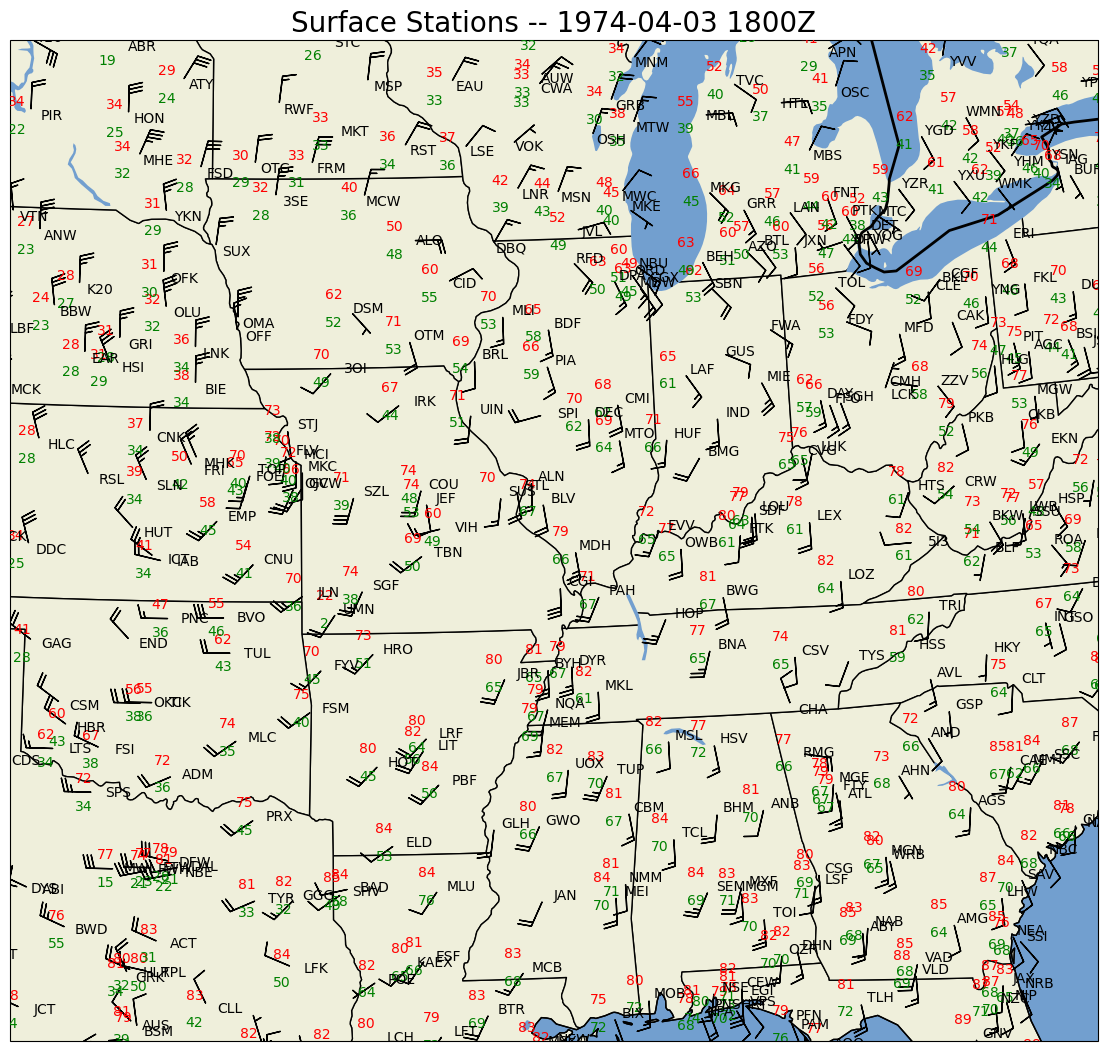

In [17]:
EXTENT = [-100,-80,30,45]
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_facecolor('#729FCF')
ax.coastlines(resolution='50m', zorder=1, color='black')
ax.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces',
                                            scale='50m',
                                            facecolor=feature.COLORS['land'],
                                            edgecolor='black'), zorder=0)
ax.add_feature(feature.NaturalEarthFeature(category='physical',
                                           name='lakes',
                                           scale='50m',
                                           facecolor='#729FCF'), zorder=0)
ax.add_feature(feature.BORDERS, linewidth=2, edgecolor='black', zorder=0)

stationplot = StationPlot(ax, stn_lon, stn_lat, clip_on=True,
                          transform=ccrs.PlateCarree(), fontsize=10)

stationplot.plot_parameter('NW', stn_T, color='red')
stationplot.plot_parameter('SW', stn_Td, color='green')
stationplot.plot_barb(stn_u, stn_v, color = 'black')
stationplot.plot_text((1.5, 0), stn_id)

ax.set_extent(EXTENT, ccrs.PlateCarree())
plt.title('Surface Stations -- 1974-04-03 1800Z', fontsize=20)

# Exporting Data

gempakIO now can export data in GEMPAK format. Perhaps you have data from some external source that you would like to plot with your favorite GEMPAK program. Importing data into GEMPAK is not always intuitive, but gempakIO can make this a fairly simple process in Python. Grid, sounding, and surface files can all be created. Here are basic examples of how to do that.

## Creating a GEMPAK Grid File

Each grid file will contain data on a single, common grid. Data will often be several atmospheric quantities (moisture, temperature, etc.) that can be at different levels, in different vertical coordinates, and at diferent times. We can make a grid using the dewpoint data that was loaded earlier.

The initial steps to creating a grid will require the coordinates (lat/lon or projected x/y) and the projection information. Unprojected lat/lon should use the equidistant cylindrical projection (CED in GEMPAK). Other possible projections are described in the [GEMPAK documentation](https://unidata.github.io/gempak/man/parm/proj.html). The dimension order for the input coordinates and data will be (y, x).

In [18]:
out_dwpt = GridFile(lon, lat, pyproj.Proj(atmo_grid.crs))

Next, we add the data to the grid with the appropriate metadata.

In [19]:
out_dwpt.add_grid(sfc_dewpt.squeeze().values, 'DWPF', None, 0, '197404031800')

Now the grid can be saved to a GEMPAK file using the `to_gempak` method.

In [20]:
# out_dwpt.to_gempak()

## Creating a GEMPAK Sounding File

Sounding files will contain a set of parameters that all vertical profiles will have. The vertical coordinates used in these file are generally going to be either height or pressure. While the parameters will not change after initialization, the location of the profile and the levels at which the data are can all vary.

The parameters that are going to be needed for display in GEMPAK are PRES, HGHT, TEMP, DWPT, DRCT (wind direction), and SPED (wind speed). Other parameters can be added as desired. For more information on sounding parameters, see the [GEMPAK documentation](https://unidata.github.io/gempak/man/parm/snparm.html).

In [21]:
out_sounding = SoundingFile(['PRES', 'HGHT', 'TEMP', 'DWPT', 'DRCT', 'SPED'])

Data is added using the `add_sounding` method. To add each parameter within the sounding, use a dictionary where the keys correspond to the parameter name and the values are arrays of the vertical profile data. For this example, the sounding data loaded earlier can be used. The location (lat/lon) of the sounding will also be needed along with some basic station metadata. If metadata is unknown, using `None` will insert blank/missing information for the profile.

In [22]:
station_meta = {
    'station_id': 'BNA',
    'station_number': 723270,
    'elevation': 180,
    'state': 'TN',
    'country': 'US'
}

In [23]:
out_sounding.add_sounding(
    {
        'PRES': p,
        'HGHT': hght,
        'TEMP': T,
        'DWPT': Td,
        'DRCT': wind_dir,
        'SPED': wind_speed
    },
    bna.lat, bna.lon, '197404031800', station_meta
)

In [24]:
# out_sounding.to_gempak()

## Create a GEMPAK Surface File

Surface files are similar to sounding files in how they are structured. A set of parameters will be present for each station that is in the file. Stations can be any location and have different times associate with them.

Ideally, to display surface data in GEMPAK, you will want to have parameters that correspond to temperature, dewpoint, wind speed, wind direction, and sky cover. The surface data loaded earlier can be used to create a new file. With some clever looping we can add multiple stations. While many GEMPAK surface files have data packed in order to compress and save space, this is not currently implemented in gempakIO. For more information on surface parameters, see the [GEMPAK documentation](https://unidata.github.io/gempak/man/parm/sfparm.html).

In [25]:
out_surface = SurfaceFile(['TMPK', 'DWPK', 'DRCT', 'SPED', 'CFRT'])

In [26]:
for station in us:
    meta = {
        'station_id': station['properties']['station_id'],
        'station_number': station['properties']['station_number'],
        'elevation': station['properties']['elevation'],
        'state': station['properties']['state'],
        'country': station['properties']['country']
    }
    out_surface.add_station(
        {
            'TMPK': station['values']['tmpk'],
            'DWPK': station['values']['dwpk'],
            'DRCT': station['values']['drct'],
            'SPED': station['values']['sped'],
            'CFRT': station['values']['cfrt'],
        },
        station['properties']['latitude'],
        station['properties']['longitude'],
        station['properties']['date_time'],
        meta
    )

In [27]:
# out_surface.to_gempak()